# Introduction

The goal of this project is to analyze data from a dataset provided by the Social Security Administration. Every year, the U.S. Social Security Administration releases data on the first names given to babies born across the country. These datasets provide a fascinating lens into cultural trends, regional differences, and shifts in naming preferences over time. The provided dataset contains the number of babies with a given name born each year, both at the national and state level. 

This project will explore the trends in popularity of names vary based on location, year, and spelling variation. It will also explore the gender ratio of births over time and investigates how pop culture events influence naming trends. 

Studying baby name trends give insights to influence to pop culture, social and cultural shifts, and gender norms. Using plots/visualizations, we will be able to see these trends and infer how they came about.

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import geopandas as gpd
from ipywidgets import interact, IntSlider, fixed

### Creating Dataframes: Names

In [2]:
file_names = glob.glob("names/yob*.txt")                            # Get a list of all files in the 'names' directory that match the pattern 'yob*.txt'

nameframes = []                                                     # Initialize an empty list to store DataFrames
for f in file_names:                                                # Loop through each file name
    nameframes.append(pd.read_csv(f,names=['Name','Sex','Count']))  # Read the CSV file and assign column names, then append to the list

years = []                                                          # Initialize an empty list to store years
for f in file_names:                                                # Loop through each file name
    FnameList = f.split('.')                                        # Split the filename to isolate the year
    year = int(FnameList[0][-4:])                                   # Extract the last 4 characters of the base name to get the year, and convert to int
    years.append(year)                                              # Append the extracted year to the years list

NameDF = pd.concat(nameframes,keys=years)                           # Concatenate all DataFrames in nameframes with years as keys for multi-indexing

NameDF = NameDF.reset_index()                                       # Reset the index to flatten the multi-index created by concat

NameDF = NameDF.rename({'level_0':'Year'},axis=1)                   # Rename the 'level_0' column to 'Year'

NameDF = NameDF.drop('level_1',axis=1)                              # Drop the 'level_1' column, which is no longer needed

NameDF.to_csv('Names.csv',index=False)                              # Save the final DataFrame to a CSV file named 'Names.csv' without the index


In [3]:
names = pd.read_csv("Names.csv")                                    # Read the 'Names.csv' file into a pandas DataFrame called 'names'

### Creating Dataframes: Names by State

In [5]:
file_names_state = glob.glob("namesbystate/*.txt")                        # Get a list of all state-specific baby name files in the 'namesbystate' folder

stateframes = []                                                          # Initialize an empty list to store DataFrames for each state

for f in file_names_state:                                                # Loop through each file in the list
    state_abbrev = os.path.basename(f).split('.')[0]                      # Extract the state abbreviation from the file name
    df = pd.read_csv(f, names=['State', 'Sex', 'Year', 'Name', 'Count'])  # Read the file into a DataFrame with specified column names
    df['State'] = state_abbrev                                            # Overwrite the 'State' column with the extracted state abbreviation
    stateframes.append(df)                                                # Append the DataFrame to the list

NameStateDF = pd.concat(stateframes, ignore_index=True)                   # Concatenate all state DataFrames into one DataFrame, resetting the index

NameStateDF.to_csv('StateNames.csv',index=False)                          # Save the combined DataFrame to a CSV file named 'StateNames.csv' without the index

In [6]:
StateNames = pd.read_csv("StateNames.csv")                                                # Load the 'StateNames.csv' file into a pandas DataFrame called 'StateNames'

## <h1><center>Name Popularity Across the US </h1></center>

### Methodology
1. Create a dictionary mapping state abbreviations to full state names to match the data with geographic shapefiles.
2. Define a `USNames` function that takes a name and year as inputs.
3. Filter the DataFrame to include only rows with the given name and year.
4. Group the filtered data by state, summing the number of babies given that name in each state.
5. Map state abbreviations to full names using the dictionary so they match the shapefile's 'NAME' field.
6. Load the US states shapefile using geopandas, then merge it with the name count data based on state names.
7. Use a choropleth map to visualize the number of babies given that name in each state using color intensity.
8. Compare to a bargraph showing the percentage of babies with that name in each state in the given year

In [7]:
def USNames(df, name, year):                                                                     # Define a function that visualizes the popularity of a given name in a given year across U.S. states
    
    state_abbrev = {'AL': 'Alabama',                                                             # Dictionary mapping state abbreviations to full names
                    'AK': 'Alaska', 
                    'AZ': 'Arizona', 
                    'AR': 'Arkansas',
                    'CA': 'California', 
                    'CO': 'Colorado', 
                    'CT': 'Connecticut', 
                    'DC': 'District of Columbia',
                    'DE': 'Delaware', 
                    'FL': 'Florida', 
                    'GA': 'Georgia', 
                    'HI': 'Hawaii',
                    'ID': 'Idaho', 
                    'IL': 'Illinois', 
                    'IN': 'Indiana', 
                    'IA': 'Iowa',
                    'KS': 'Kansas',
                    'KY': 'Kentucky', 
                    'LA': 'Louisiana', 
                    'ME': 'Maine', 
                    'MD': 'Maryland', 
                    'MA': 'Massachusetts',
                    'MI': 'Michigan', 
                    'MN': 'Minnesota',
                    'MS': 'Mississippi', 
                    'MO': 'Missouri', 
                    'MT': 'Montana', 
                    'NE': 'Nebraska',
                    'NV': 'Nevada', 
                    'NH': 'New Hampshire', 
                    'NJ': 'New Jersey', 
                    'NM': 'New Mexico',
                    'NY': 'New York', 
                    'NC': 'North Carolina', 
                    'ND': 'North Dakota', 
                    'OH': 'Ohio',
                    'OK': 'Oklahoma', 
                    'OR': 'Oregon', 
                    'PA': 'Pennsylvania', 
                    'RI': 'Rhode Island',
                    'SC': 'South Carolina', 
                    'SD': 'South Dakota', 
                    'TN': 'Tennessee', 
                    'TX': 'Texas',
                    'UT': 'Utah', 
                    'VT': 'Vermont', 
                    'VA': 'Virginia', 
                    'WA': 'Washington',
                    'WV': 'West Virginia', 
                    'WI': 'Wisconsin', 
                    'WY': 'Wyoming'
                   }

    filtered = df[(df['Name'] == name) & (df['Year'] == year)]                                   # Filter the DataFrame for rows with the specified name and year

    name_counts = filtered.groupby('State')['Count'].sum().reset_index()                         # Group by state and sum the counts of the name, then reset index
    name_counts['StateName'] = name_counts['State'].map(state_abbrev)                            # Map state abbreviations to full state names

    us_states = gpd.read_file('cb_2018_us_state_20m.shp')                                        # Load U.S. state shapefile for mapping

    geo = us_states.merge(name_counts, left_on='NAME', right_on='StateName')                     # Merge the shapefile data with name count data on state names

    geo = geo.cx[-130:-65, 24:50]                                                                # Crop the map to the continental U.S. region

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))                                               # Create a figure and axis for plotting
    geo.plot(column='Count', cmap='plasma', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)  # Plot the data as a choropleth map with color scale
    plt.title(f"Popularity of the name {name} in {year}", fontsize=16)                           # Add a title to the plot
    plt.axis('off')                                                                              # Remove the axis lines and ticks for a cleaner look
    plt.show()                                                                                   # Display the plot


In [10]:
def totalVsName(df, name, year):                                                                # Define a function to compare total births vs. a specific name's births across states for a given year

    df_year = df[df["Year"] == year]                                                            # Filter the DataFrame for the specified year

    total_by_state = df_year.groupby("State")["Count"].sum()                                    # Group by state and sum total births for all names
    name_by_state = df_year[df_year["Name"] == name].groupby("State")["Count"].sum()            # Group by state and sum births for the specified name

    plot_df = pd.DataFrame({"Total": total_by_state, name: name_by_state}).fillna(0)            # Create a new DataFrame combining total and name-specific counts; fill missing values with 0

    plot_df["Percent"] = 100 * plot_df[name] / plot_df["Total"]                                 # Calculate the percentage of births with the given name in each state

    plot_df = plot_df.reset_index().sort_values("State")                                        # Reset the index and sort the DataFrame by state name

    plt.figure(figsize=(12, 6))                                                                 # Create a new figure with specified size

    plt.bar(plot_df["State"], plot_df["Total"], color="lightgray", label="Total Births")        # Plot total births as gray bars

    sns.barplot(data=plot_df, x="State", y=name, color="steelblue", label=f"'{name}' Births")   # Overlay name-specific births as blue bars using seaborn

    for idx, row in plot_df.iterrows():                                                         # Loop through each row in the DataFrame
        plt.text(
            x=idx,                                                                              # X-position of the label
            y=row["Total"] + max(plot_df["Total"]) * 0.01,                                      # Y-position just above the total bar
            s=f"{row['Percent']:.1f}%",                                                         # Display the percentage as text (e.g., 3.4%)
            ha='center',                                                                        # Horizontally center the text
            va='bottom',                                                                        # Vertically align text to the bottom
            fontsize=8                                                                          # Set font size of the label
        )

    plt.title(f"Total Births vs. {name} Births per State in {year}")                            # Set the plot title
    plt.xlabel("State")                                                                         # Label the x-axis
    plt.ylabel("Number of Births")                                                              # Label the y-axis
    plt.xticks(rotation=90)                                                                     # Rotate x-axis labels for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)                                               # Add horizontal grid lines for visual clarity
    plt.legend()                                                                                # Show the legend
    plt.tight_layout()                                                                          # Automatically adjust subplot parameters for neat layout
    plt.show()                                                                                  # Display the plot

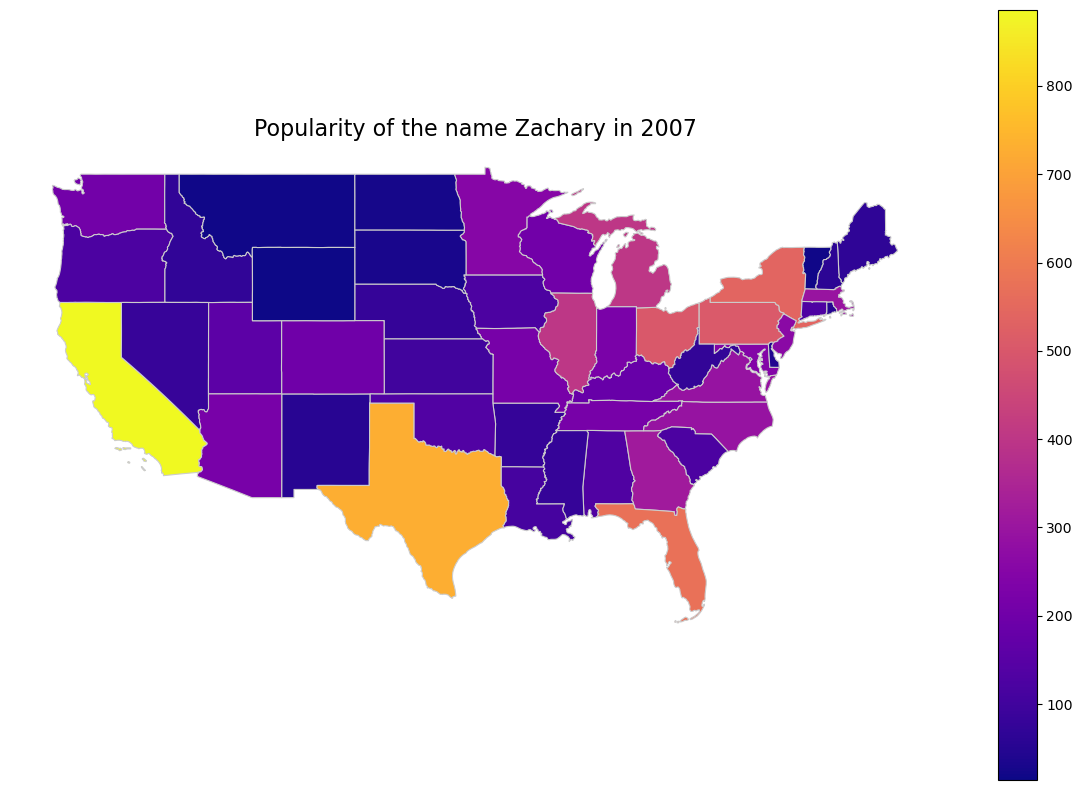

In [19]:
USNames(StateNames, "Zachary", 2007)

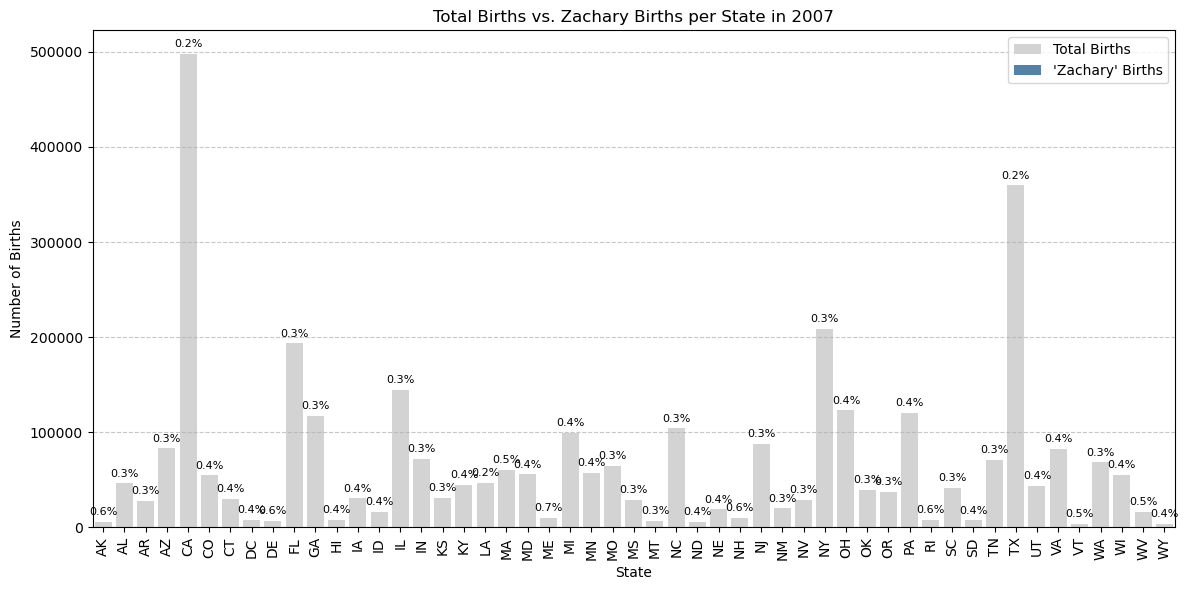

In [21]:
totalVsName(StateNames, "Zachary", 2007)

The two graphs above can be used to view trends in naming across the US. The first graphs is a choropath graph that shows name popularity across the US. The second graph dives deeper and shows the popularity of the name in each state compared to the total number of births. These graphs can be used to visually show how names are favored in different communities.

## <h1><center>Battle of the Sexes</h1></center>

### Methodology
1. Create a line graph to show the fluctionation in the number of female vs. male births
2. Define a function `genderByState` that takes a year and state list as input.
3. Filter the DataFrame to only include rows from the given year.
4. Group the data by state and gender, summing the counts of births.
5. Use bar graphs to compare male vs. female births across each state for 1930, 1960, and 1990.
6. Interpret patterns by looking at whether male or female births outnumbered the other over time and location.

In [23]:
def genderTrendOverTime(df):                                       # Define a function to visualize male vs. female birth trends over time

    trend = df.groupby(["Year", "Sex"])["Count"].sum().unstack()   # Group the data by year and sex, sum the birth counts, and unstack to create a table with sexes as columns

    plt.figure(figsize=(12, 6))                                    # Create a new figure with a specified size
    sns.lineplot(data=trend, linewidth=2)                          # Plot the trend as a line graph using seaborn with thicker lines

    plt.title("Total Male vs. Female Births in the US Over Time")  # Set the plot title
    plt.xlabel("Year")                                             # Label the x-axis
    plt.ylabel("Number of Births")                                 # Label the y-axis
    plt.grid(True)                                                 # Enable grid lines on the plot
    plt.legend()                                                   # Display the legend to distinguish between male and female lines
    plt.tight_layout()                                             # Automatically adjust layout to fit all elements neatly
    plt.show()                                                     # Display the plot


In [25]:
def genderByState(df, year):                                                          # Define a function to visualize male vs. female birth counts per state for a given year

    df_year = df[df["Year"] == year]                                                  # Filter the DataFrame to include only rows from the specified year

    grouped = df_year.groupby(["State", "Sex"])["Count"].sum().unstack(fill_value=0)  # Group by state and sex, sum the counts, and unstack so each sex is a column; fill missing values with 0

    grouped["Total"] = grouped["F"] + grouped["M"]                                    # Calculate the total number of births per state
    grouped["Percent_F"] = 100 * grouped["F"] / grouped["Total"]                      # Calculate the percentage of female births per state
    grouped["Percent_M"] = 100 * grouped["M"] / grouped["Total"]                      # Calculate the percentage of male births per state

    grouped = grouped.sort_index()                                                    # Sort the DataFrame by state name

    states = grouped.index.tolist()                                                   # Get a list of state names
    x = np.arange(len(states))                                                        # Create an array of evenly spaced values for x-axis positions
    width = 0.35                                                                      # Set the width of each bar in the bar plot

    plt.figure(figsize=(14, 6))                                                       # Create a new figure with a specified size

    plt.bar(x - width/2, grouped["F"], width, label="Female", color="lightcoral")     # Plot the female birth counts as left bars (red)

    plt.bar(x + width/2, grouped["M"], width, label="Male", color="cornflowerblue")   # Plot the male birth counts as right bars (blue)

    plt.title(f"Battle of the Sexes: Male vs. Female Births per State in {year}")     # Set the plot title
    plt.xlabel("State")                                                               # Label the x-axis
    plt.ylabel("Number of Births")                                                    # Label the y-axis
    plt.xticks(x, states, rotation=90)                                                # Set x-axis labels to state names, rotated vertically for readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)                                     # Add horizontal dashed grid lines for clarity
    plt.legend()                                                                      # Display the legend to distinguish between male and female bars
    plt.tight_layout()                                                                # Automatically adjust layout to fit elements neatly
    plt.show()                                                                        # Display the plot


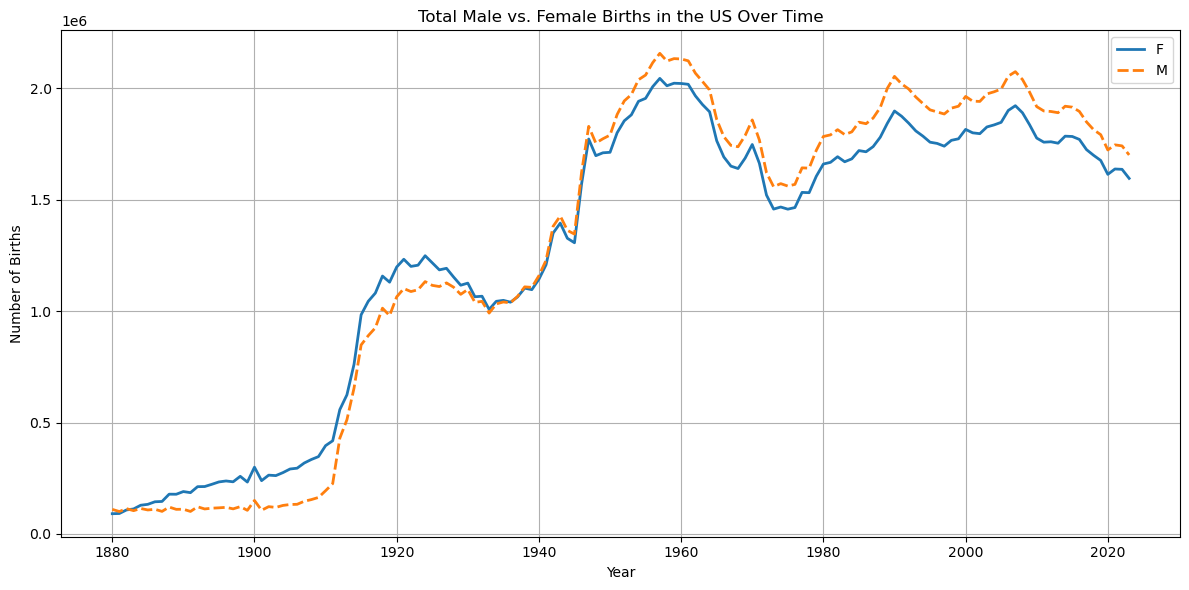

In [276]:
genderTrendOverTime(names)

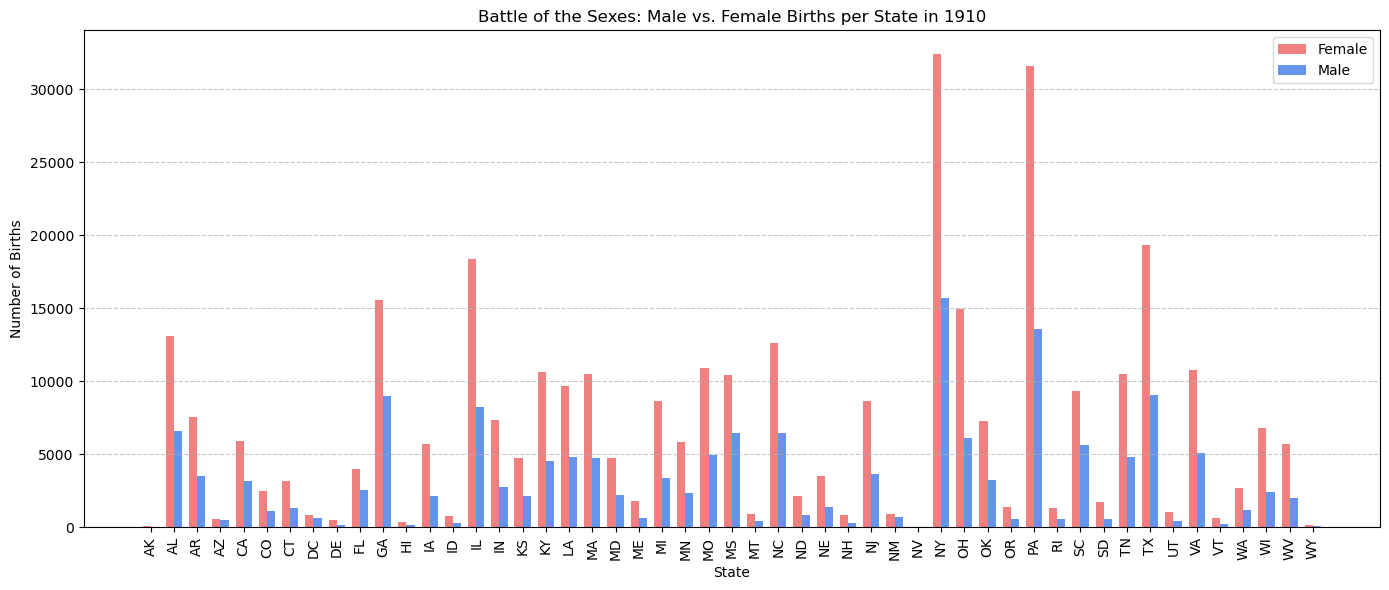

In [494]:
genderByState(StateNames, 1910)

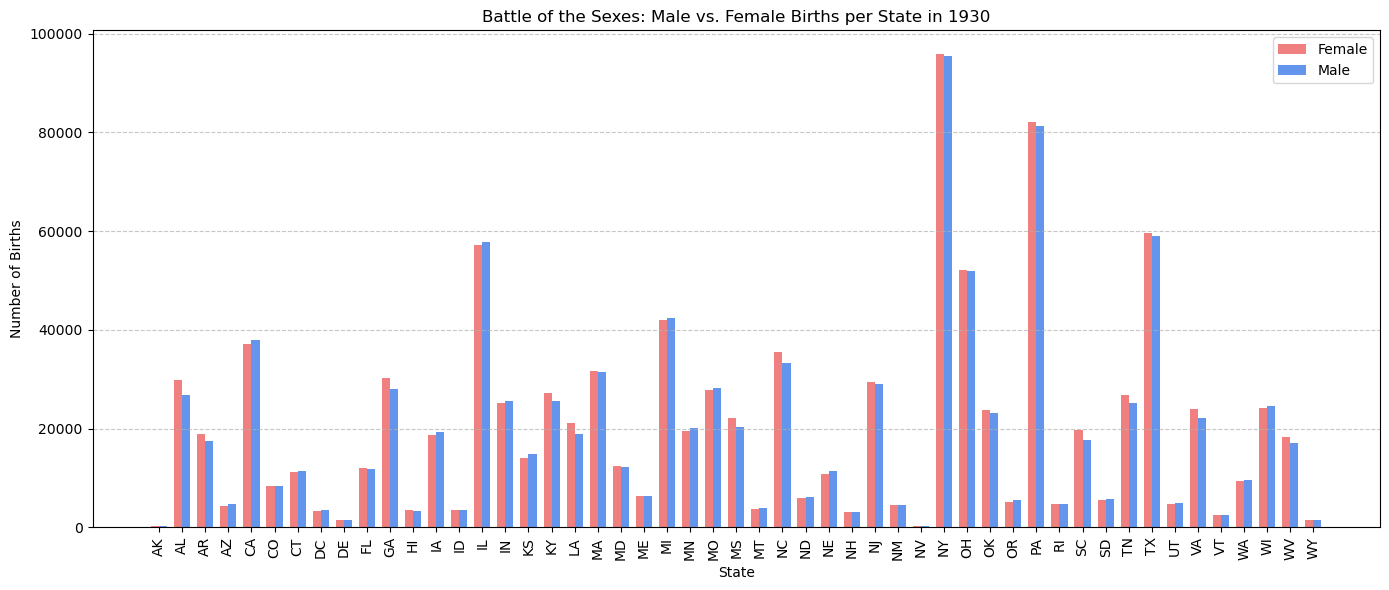

In [500]:
genderByState(StateNames, 1930)

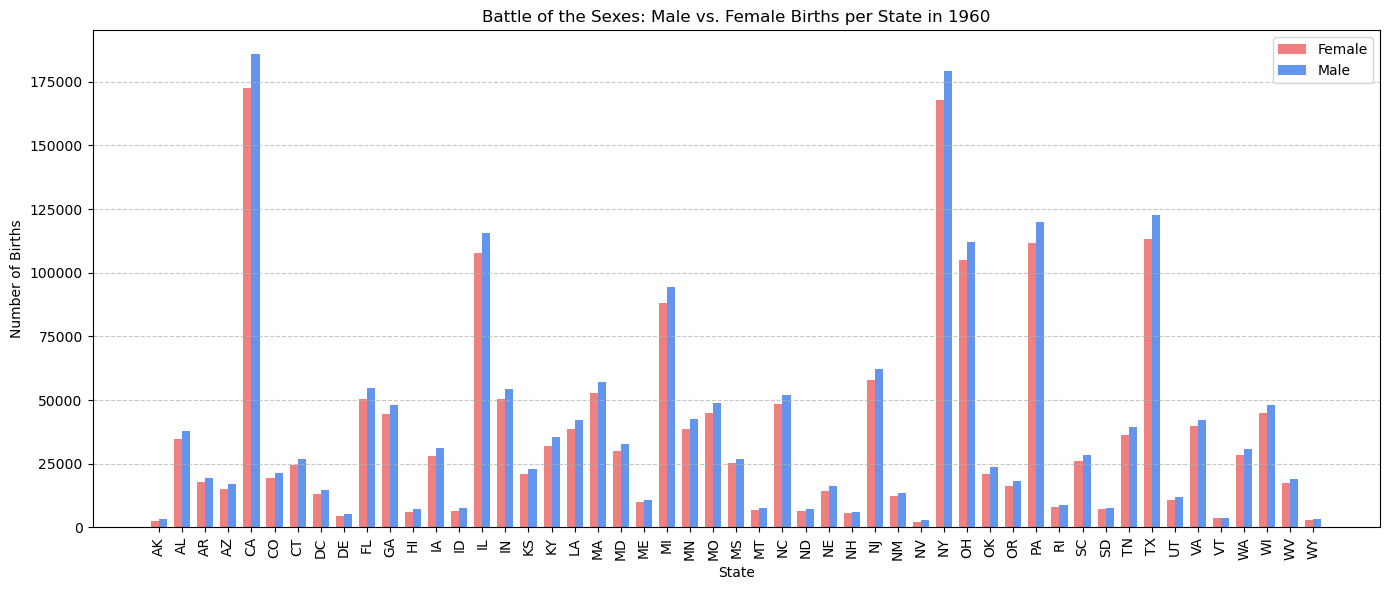

In [502]:
genderByState(StateNames, 1960)

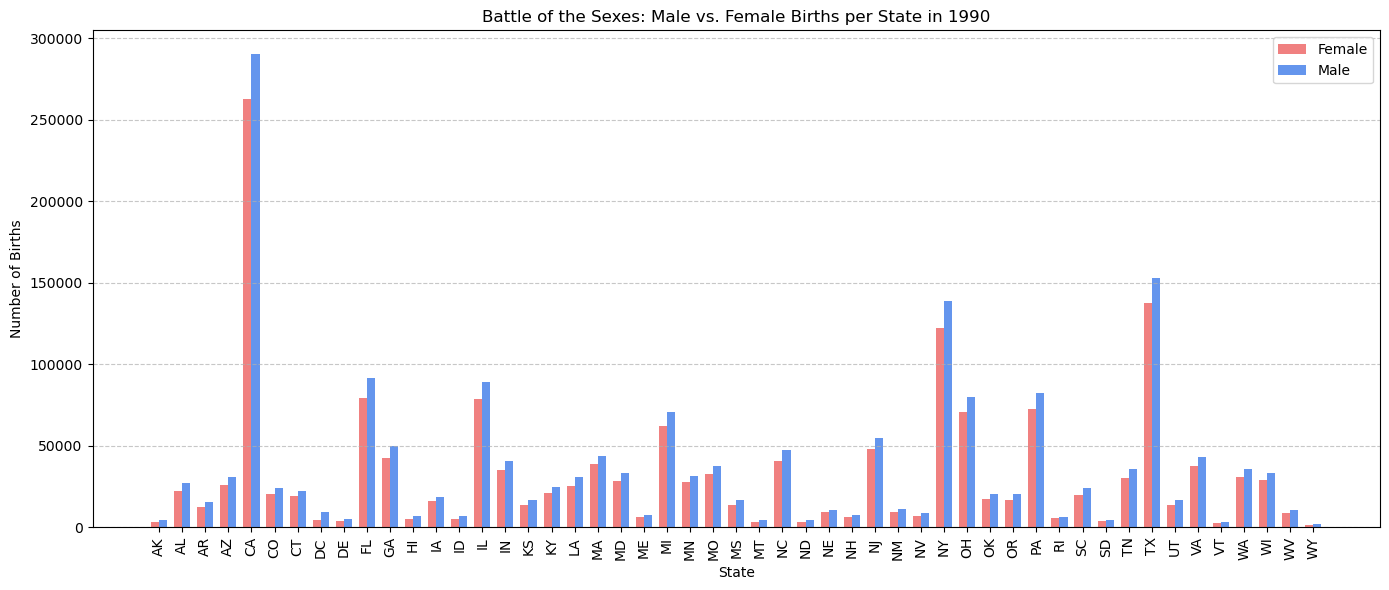

In [504]:
genderByState(StateNames, 1990)

The graphs above investigate gender-based trends. The first type of graph shows the flucuation in the ratio of total female births to total male births over time. Using this graph you can see long term trends in number of births. Here we can see that for about 60 years, female births outnumbered male births. After 1930, that trend shifted and from 1930 up until present day, male births have outnumbered female births.

With the second type, we can get a closer look at the difference by comparing male and female births per state for a specific state. This plot reveals how gender distribution of birth varies across diffrent states. We can see as time passes, for states with larger populations, the ratio of female to male babies is realtively consistant after 1930. 

## <h1><center>Name Variations</h1></center>

### Methodology
1. Define lists of name variations
2. Create a `NameVariations` function that filters the DataFrame by name variations and gender
3. Group the data by name and year, summing counts for each spelling
4. Pivot the grouped DataFrame so each column represents a name variation and each row a year
5. Fill any missing values with 0 to avoid blank heatmap cells
6. Generate heatmaps to visualize the rise and fall in popularity of each name spelling over time

In [593]:
def NameVariations(df, name_variations, sex):                                          # Define a function to visualize the popularity of different spellings of a name over time for a given gender

    df_filtered = df[(df['Name'].isin(name_variations)) & (df['Sex'] == sex)]          # Filter the DataFrame to include only rows with specified name variants and gender

    df_grouped = df_filtered.groupby(['Year', 'Name'], as_index=False)['Count'].sum()  # Group by year and name, summing counts to get total births for each variant per year

    pivot_df = df_grouped.pivot(index='Year', columns='Name', values='Count')          # Pivot the DataFrame so each column is a name variant and rows represent years

    pivot_df = pivot_df.fillna(0)                                                      # Replace any missing values with 0 (no births for that name in that year)

    plt.figure(figsize=(12, 8))                                                        # Create a new figure with specified dimensions
    sns.heatmap(pivot_df, fmt=".0f", cmap="plasma")                                    # Plot the data as a heatmap with integer formatting and a plasma color scale
    plt.title(f"Popularity of {name_variations[0]} Over Time")                         # Set the plot title using the first name variant as a representative label
    plt.xlabel("Name Variant")                                                         # Label the x-axis
    plt.ylabel("Year")                                                                 # Label the y-axis
    plt.tight_layout()                                                                 # Adjust layout for clean spacing
    plt.show()                                                                         # Display the plot

In [567]:
Alison_Variations = ['Alison', 'Allison', 'Alyson', 'Allyson', 'Alysson']
Sarah_Variations = ['Sarah','Sara']
Aiden_Variations = ["Aiden", 'Aaden', 'Adan', 'Aden', 'Aidan', 'Ayden']
Sean_Variations = ["Sean", "Shawn", "Shaun", "Shon", "Shaan", "Séan"]

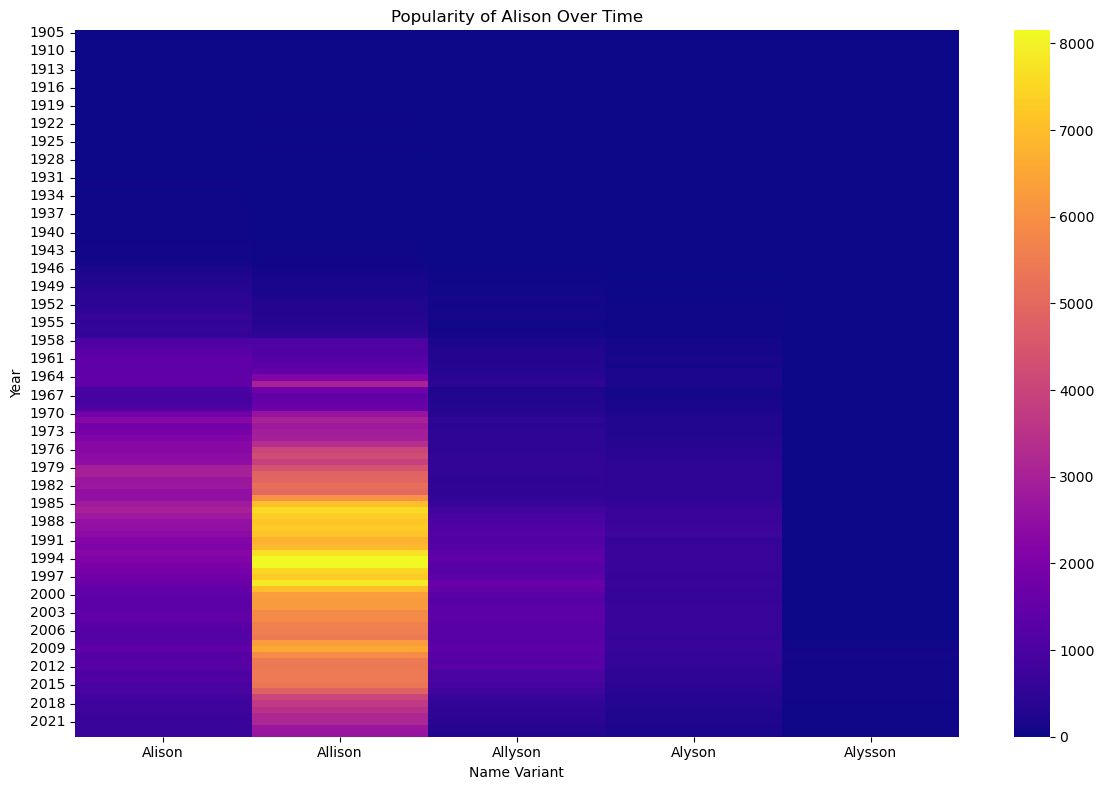

In [553]:
NameVariations(names, Alison_Variations, "F")

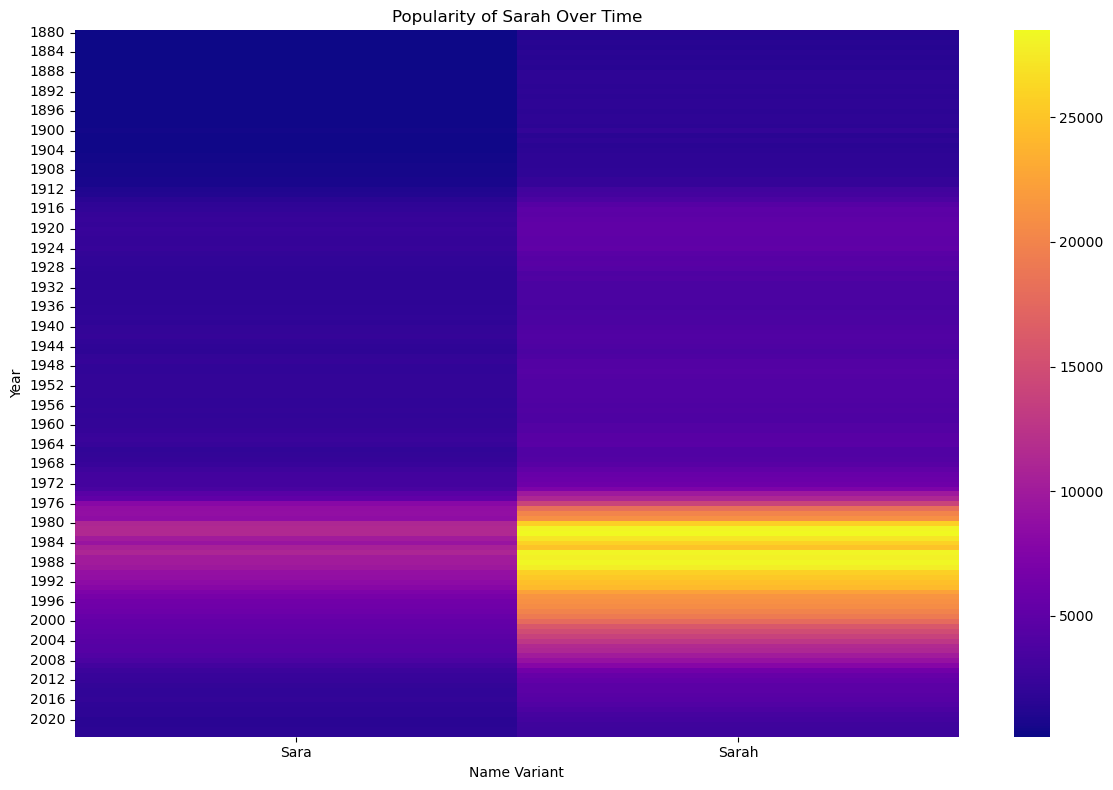

In [555]:
NameVariations(names, Sarah_Variations, "F")

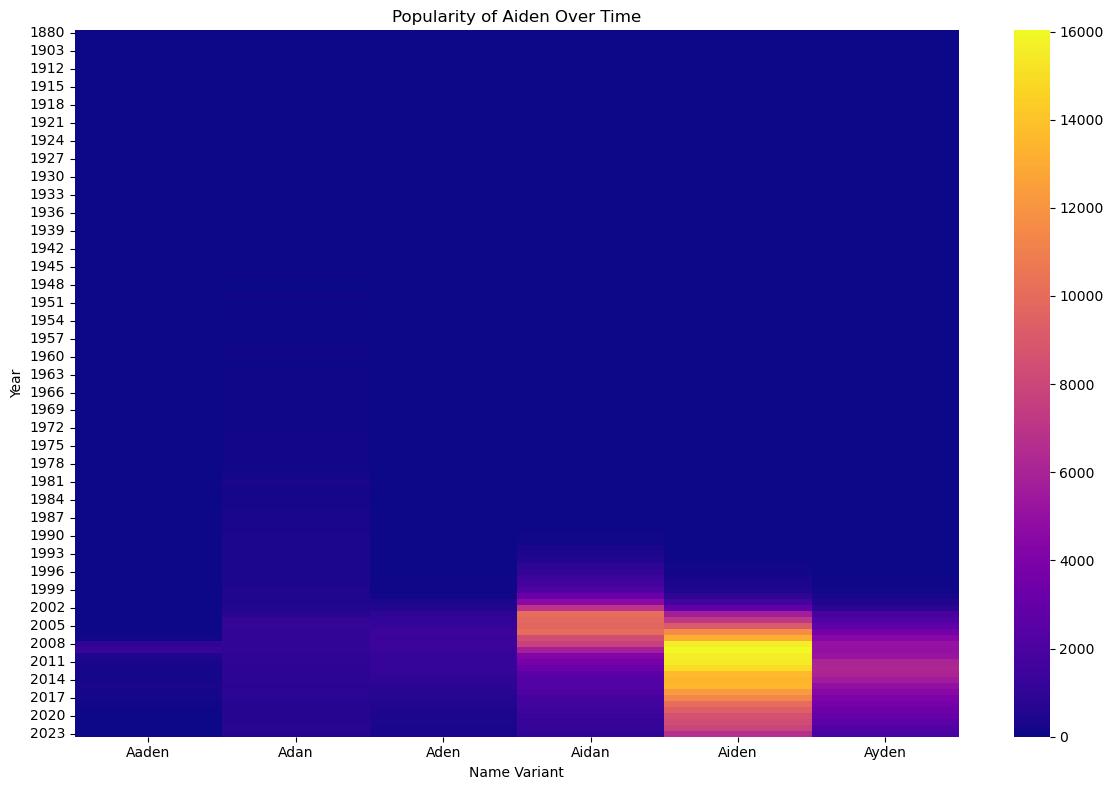

In [557]:
NameVariations(names, Aiden_Variations, "M")

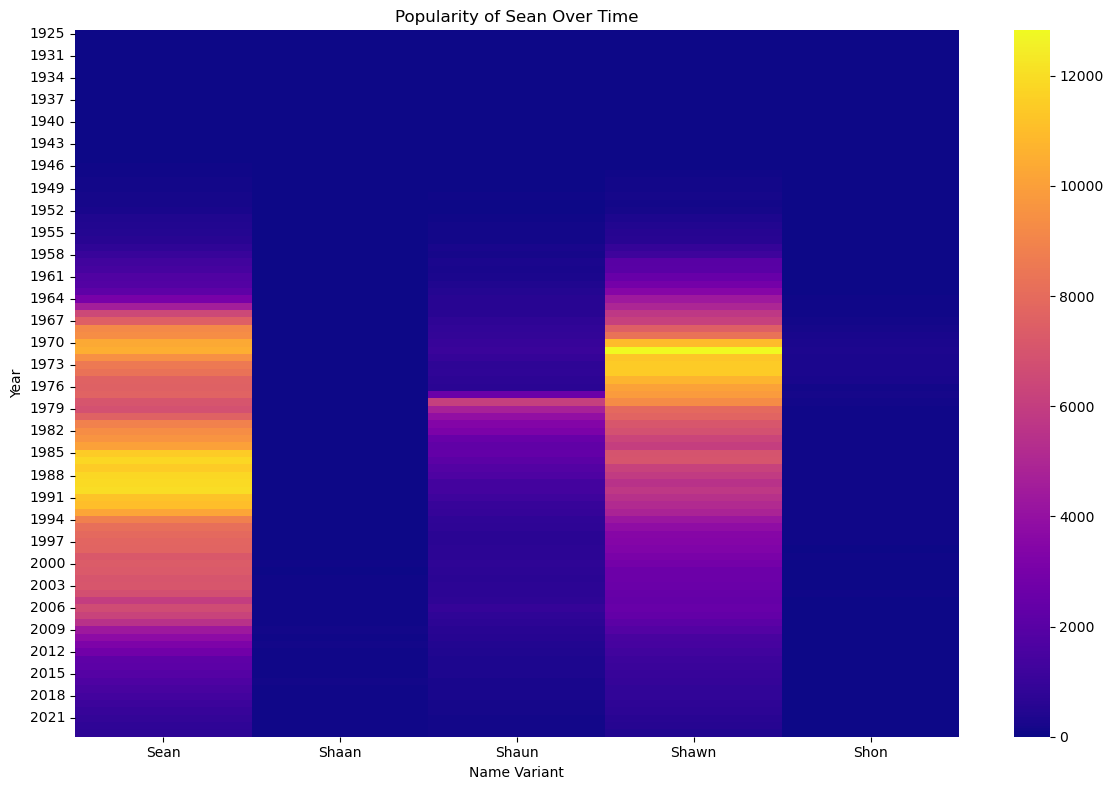

In [569]:
NameVariations(names, Sean_Variations, "M")

The graphs above shows name spelling trends. Using a heatmaps color intensity, we can see the years each variation was popular. This visualization is particularly effective for identifying shifts in popularity, emergence of newer spellings, or even temporary spikes that might reflect cultural or celebrity influence. 

The variations of "Alison" we can see a rise to populaity in the "Allison" variation from the 1970s through the early 2000s. Looking at the two variations of "Sarah" we can see that there was a massive peak in popularity of "Sarah" in the 1980s and that popularity lasted until the early 2000s. Variants of "Aiden" became extremely popular in the early 2000s. Sean's variariations peaked in popularity between the 1970s and 1990s. 

## <h1><center>Name Popularaity vs. Popular Media</center></h1>

### Methodology
1. Create lists of character names from major media franchises (Hunger Games, Marvel, Star Wars, etc.).
2. Build dictionaries of movie/book/show titles with their release years.
3. Define a `FranchiseVsName` function that filters the DataFrame by name list and plots name frequency over time.
4. Overlay vertical lines on line graphs at each franchise event year (movies, books, etc.).
5. Interpret trends by connecting name spikes/drops to the release of pop culture media featuring the characters.

In [284]:
def FranchiseVsName(df, nameList, movie, movies, books, tvShow, startyear):                                    # Define a function to plot name trends over time alongside media release dates

    df_filtered = df[df['Name'].isin(nameList)]                                                                # Filter the DataFrame to only include rows where the name is in the specified list

    df_filtered_year = df_filtered[df_filtered['Year'] >= startyear]                                           # Further filter the data to only include years from the start year onward

    df_grouped = df_filtered_year.groupby(['Year', 'Name'])['Count'].sum().reset_index()                       # Group by year and name, summing counts, and reset index for plotting

    plt.figure(figsize=(10, 5))                                                                                # Create a new figure with specified dimensions

    for name in nameList:                                                                                      # Loop through each name in the list
        name_data = df_grouped[df_grouped['Name'] == name]                                                     # Filter data for the current name
        plt.plot(name_data['Year'], name_data['Count'], label=name)                                            # Plot the name's trend line with a label

    if movies:                                                                                                 # If a dictionary of movies is provided
        for title, year in movies.items():                                                                     # Loop through each movie title and its release year
            plt.axvline(x=year, color='gray', linestyle='--', alpha=0.6)                                       # Add a vertical dashed line at the movie release year
            plt.text(year + 0.1, plt.ylim()[1]*0.95, title, rotation=90, verticalalignment='top', fontsize=9)  # Add a vertical text label above the line

    if books:                                                                                                  # If a dictionary of books is provided
        for title, year in books.items():                                                                      # Loop through each book title and year
            plt.axvline(x=year, color='blue', linestyle='--', alpha=0.6)                                       # Add a vertical blue line at the book release year
            plt.text(year + 0.1, plt.ylim()[1]*0.95, title, rotation=90, verticalalignment='top', fontsize=9)  # Add a vertical label for the book

    if tvShow:                                                                                                 # If a dictionary of TV shows is provided
        for title, year in tvShow.items():                                                                     # Loop through each TV show title and year
            plt.axvline(x=year, color='blue', linestyle='--', alpha=0.6)                                       # Add a vertical blue line for the TV show release
            plt.text(year + 0.1, plt.ylim()[1]*0.95, title, rotation=90, verticalalignment='top', fontsize=9)  # Add a label for the TV show

    plt.title(f'Name Popularity vs the {movie} Franchise')                                                     # Set the title of the plot
    plt.xlabel('Year')                                                                                         # Label the x-axis
    plt.ylabel('Total Names')                                                                                  # Label the y-axis
    plt.legend()                                                                                               # Display the legend
    plt.grid(False)                                                                                            # Disable the grid lines
    plt.tight_layout()                                                                                         # Adjust layout to fit elements nicely
    plt.show()                                                                                                 # Display the plot


In [337]:
# The Hunger Games Franchise

HGList = ["Katniss", "Primrose", "Peeta", "Gale", "Haymitch","Rue", "Finnick", "Coriolanus"]  # List of character names from The Hunger Games franchise to track in baby name data

HGMovieList = {"The Hunger Games (2012)" : 2012,                                              # Dictionary of Hunger Games movie titles and their release years
              "The Hunger Games: Catching Fire (2013)" : 2013,
              "The Hunger Games: Mockingjay Pt. 1 (2014)" : 2014,
              "The Hunger Games: Mockingjay pt. 2 (2015)" : 2015,
              "The Ballad of Songbirds & Snakes (2023)" : 2023}

HGBookList = {"Hunger Games - 2008" : 2008,                                                   # Dictionary of Hunger Games book titles and their publication years
              "Catching Fire - 2009" : 2009,
              "Mockingjay - 2010" : 2010,
              "The Ballad of Songbirds and Snakes - 2020" : 2020,
              "Sunrise on the Reaping - 2025" : 2025}  

HGShowList = {}                                                                               # Empty dictionary indicating no TV shows for the Hunger Games franchise


In [354]:
# The Marvel Cinimatic Universe

MCUList = ["Tony", "Steven", "Natasha", "Bruce", "Pepper","Peter", "Peggy"]  # List of major MCU character names to track in name popularity data

MCUMovieList = {"Iron Man, The Incredible Hulk - 2008" : 2008,               # Dictionary of selected MCU movie titles and their release years
                #"The Incredible Hulk - 2008" : 2008,  
                "Iron Man 2 -2010" : 2010,
                #"Thor - 2011" : 2011,  
                "Captain America: The First Avenger, Thor- 2011" : 2011,
                "The Avengers - 2012" : 2012,
                "Iron Man 3 - 2013" : 2013,
                "Captain America: The Winter Soldier - 2014" : 2014,
                #"Guardians of the Galaxy - 2014" : 2014,  
                "Avengers: Age of Ultron - 2015" : 2015,
                "Captain America: Civil War - 2016" : 2016,
                "Spiderman: Homecoming - 2017" : 2017,
                "Black Panther, Avengers: Infinity War - 2018" : 2018,
                "Avengers: Endgame - 2019" : 2019                
               }

MCUBookList = []                                                              # No MCU book releases included in this analysis
MCUShowList = []                                                              # No MCU TV shows included in this analysis


In [367]:
# The Star Wars Franchise

SWList = ["Luke", "Leia", "Han", "Anakin", "Rey", "Kylo", "Finn"]   # List of major Star Wars character names to track in baby name data

SWMovieList = {"Episode 4 - A New Hope (1977)" : 1977,              # Dictionary of Star Wars movie titles and their release years
               "Episode 5 - The Empire Strikes Back (1980)" : 1980,
               "Episode 6 - Return of the Jedi (1983)" : 1983,
               "Episode 1 - The Phantom Menace (1999)" : 1999,
               "Episode 2 - Attack of the Clones (2002)" : 2002,
               "Episode 3 – Revenge of the Sith (2005)" : 2005,
               "Episode 7 - The Force Awakens (2015)" : 2015,
               "Rogue One: A Star Wars Story (2016)": 2016,
               "Episode 8 - The Last Jedi (2017)" : 2017,
               "Solo: A Star Wars Story (2018)" : 2018,
               "Episode 9 - The Rise of Skywalker (2019)" : 2019
              }

SWBookList = []                                                     # No Star Wars book releases included in this analysis
SWShowList = []                                                     # No Star Wars TV shows included in this analysis


In [288]:
# The Divergent Franchise

DList = ["Tris", "Beatrice", "Caleb", "Tobias", "Christina"]                 # List of main character names from the Divergent series to track in name data

DMovieList = {"Divergent (2014)" : 2014,                                     # Dictionary of Divergent movie titles and their release years
              "The Divergent Series: Insurgent (2015)" : 2015,
              "The Divergent Series: Allegiant (2016)" : 2016
             }

DBookList = {"Divergent - 2011" : 2011,                                      # Dictionary of Divergent book titles and their publication years
             "Insurgent - 2012" : 2012,
             "Allegiant - 2013" : 2013,
             #"Four: A Divergent Collection - 2014" : 2014,  
             "We Can Be Mended: A Divergent Series Epilogue - 2018" : 2018}

DShowList = []                                                               # No Divergent TV shows included in this analysis


In [352]:
# The Twilight Franchise

TList = ["Isabella", "Edward", "Jacob", "Alice", "Carlisle", "Esme", "Jasper", "Rosalie", "Emmett"]  # List of main character names from the Twilight series to track in baby name data

TMovieList = {"Twilight (2008)": 2008,                                                               # Dictionary of Twilight movie titles and their release years
              "The Twilight Saga: New Moon (2009)": 2009,
              "The Twilight Saga: Eclipse (2010)": 2010,
              "The Twilight Saga: Breaking Dawn – Part 1 (2011)" : 2011,
              "The Twilight Saga: Breaking Dawn – Part 2 (2012)" : 2012
             }

TBookList = {"Twilight - 2005" : 2005,                                                               # Dictionary of Twilight book titles and their publication years
             "New Moon - 2006" : 2006,
             "Eclipse - 2007" : 2007,
             "Breaking Dawn,                       ," : 2008,  
            # "The Short Life of Bree Tanner - 2010" : 2010,  
             "Life and Death - 2016" : 2016,
             "Midnight Sun - 2020" : 2020
            }

TShowList = []                                                                                       # No Twilight TV shows included in this analysis


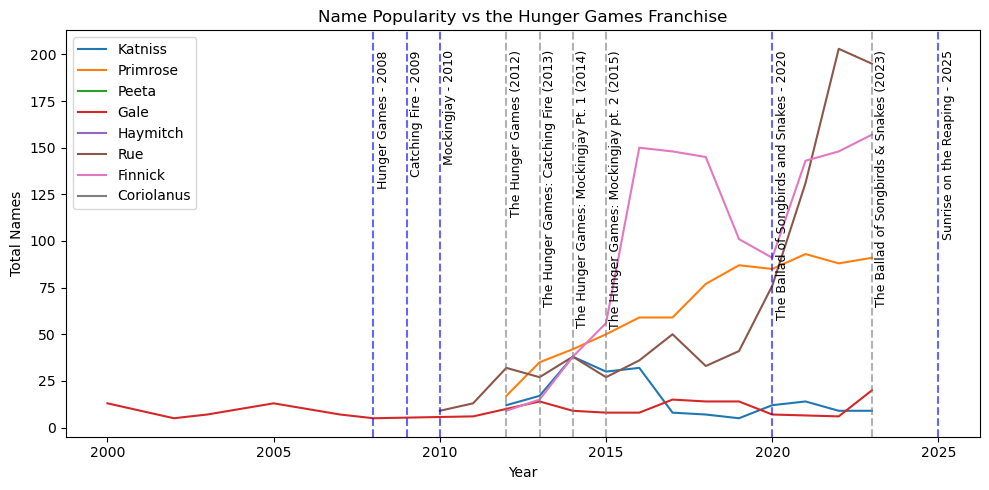

In [341]:
FranchiseVsName(names, HGList, "Hunger Games", HGMovieList, HGBookList, HGShowList, 2000)

| Character     | Observations       |
|----------------|----------------|
| Katniss        | The name Katniss appeared on the census following the release of the Hunger Games movie. It increased in popularity as more movie adaptations were released and then popularity decreased until the trilogy's prequel, The Ballad of Songbirds and Snakes, hit the bookshelves.         |
| Primrose       | Like Katniss, the name Primrose became popular following the first movie in the franchise. Unlike Katniss, the name has had realtively linear growth in popularity.         |
| Peeta          | Nobody wanted to name their child after this character.        |
| Gale           | There was a slight increase in popularity, but overall the amount of babies being named Gale stayed the same, never exceeding 25 babies each year.       |
| Haymitch       | Nobody wanted to name their chiled after this character.       |
| Rue            | Looking at this graph, we can see the name Rue gained populaity after the third book in the Hunger Games trilogy was released. During the release of the movies, the name's popularity slowly increased until 2019 where it skyrocketed from about 50 babies to over 200. This happened before and after the realease of the Hunger Game's prequel. Though this was also during a popular TV show which also has a character named Rue.        |
| Finnick        | Finnick showed up the same year the first movie was released. It gained popularity after the release of the second movie, the first time the character was on the screen, and then took off after the final movie. This increase of babies being named Finick may be a result of and event that occured in the book/movie. The name began losing popularity until the release of the prequel where it increased again.       |
| Coriolanus     | Nobody wanted to name their child after this character.       |


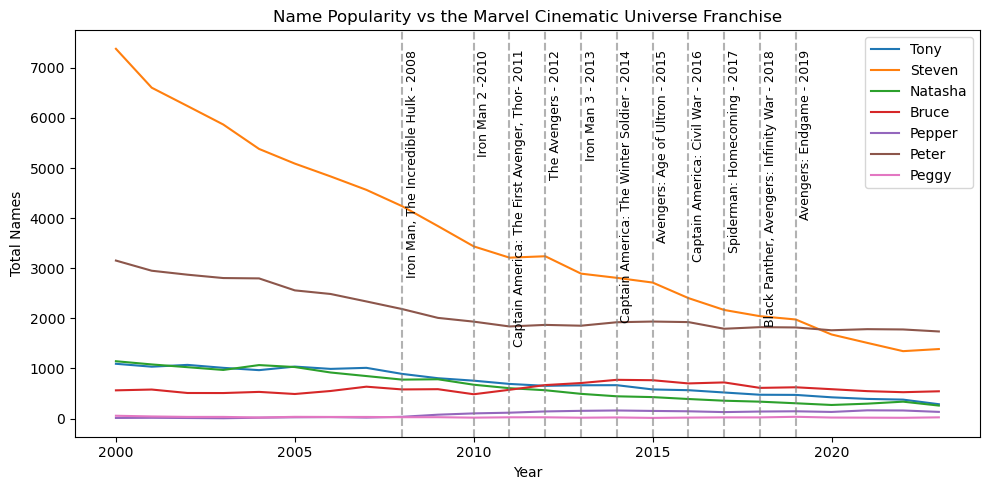

In [356]:
FranchiseVsName(names, MCUList, "Marvel Cinematic Universe", MCUMovieList, MCUBookList, MCUShowList, 2000)

| Character      | Observations   |
|----------------|----------------|
| Tony           | The instances of babies being named Tony slowly decreased as movies were released. The popularity of the franchise seems to cause a dislike of the name Tony.         |
| Steven         | Just like Tony, the name Steven is slowly going out of style. The number of babies being named Steven did even out for a year after Captain America: The First Avenger was released before continuing on the downward trend.  |
| Natasha        | Natasha also doesn't seem to be affected by the popularity of the movies      |
| Bruce          | The name Bruce gained popularity as the more movies were released, but after Spiderman- Homecoming, populaity began decreasing.        |
| Pepper         | Babies named Pepper began appearing on the census in 2008 after the release of Iron Man. It has continued to grow at a slow, positiive rate.         |
| Peter          | Captain America: Civil War had a slight negative affect on babies being named Peter, but that drop in names was recovered by Spiderman: Homecoming and Avengers: Infinity War and Endgame.        |
| Peggy          | There was no change in the popularity of the name Peggy.        |

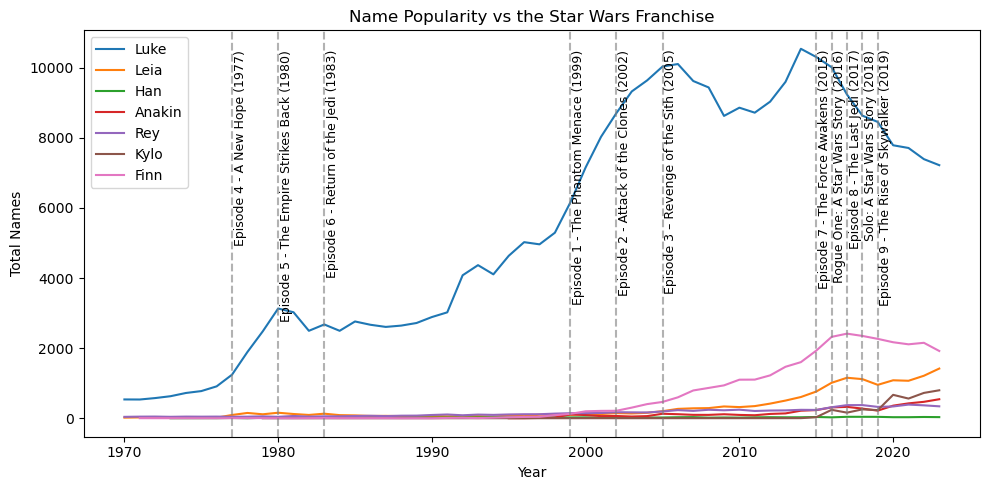

In [369]:
FranchiseVsName(names, SWList, "Star Wars", SWMovieList, SWBookList, SWShowList, 1970)

| Character      | Observations   |
|----------------|----------------|
| Luke           | Popularity of the name Luke spiked after the realease of the first Star Wars movie, Episode 4 - A New Hope. Despite a list decrease in popularity, it began growing in the 1990s and took off after the release of the first prequel, Episode 1 - The Phantom Menace. The number of babies with the name Luke grew for the next six years before it dropped again. There was a small growth in the Luke population before release of Episode 7, and then popularity began decreasing very quickly.        |
| Leia           | Leia had a blip of popularity during the original movies, Episodes 4,5, and 6. It then began growing exponentially after the release of Episode 1 until Episode 8. Popularity of the name fell until Episode 9 when the name Leia became the most popular it's ever been.         |
| Han            | Only a few people wanted to name their children Han and the Han population has stayed consistant for over 50 years.         |
| Anakin         | While gaining traction in the 90s, the name Anakin has had slow exponential growth in popularity since the release of Episode 1.       |
| Rey            | Popularity of the name Rey has been slowly increasing since Episode 5. There was a increase while Episodes 7-9 were being released.   |
| Kylo           | The name Kylo was given to children after the release of Episode 7, when the character of Kylo Ren first appeared in the movies.      |
| Finn           | The Finn population grew steadily from 2000, the year Episode 1 was released, until 2017, the year of Episode 8 - The Last Jedi.       |

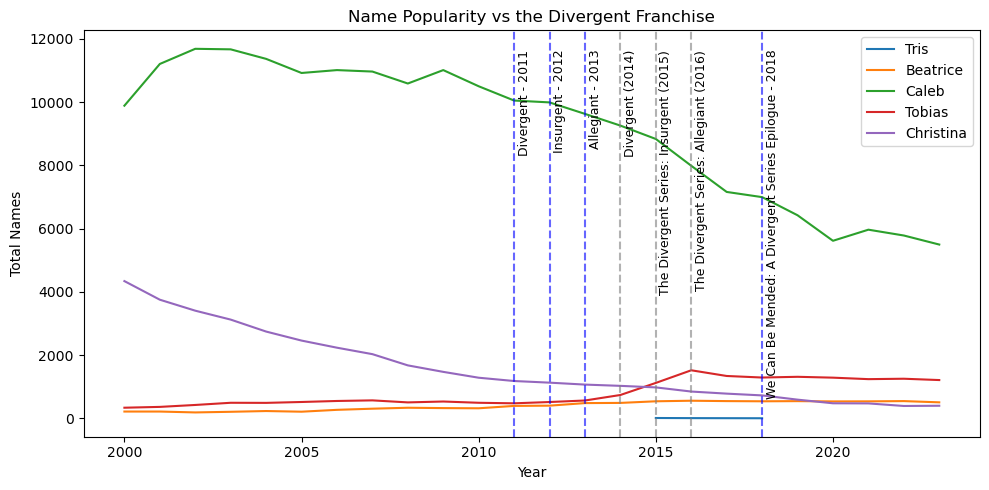

In [293]:
FranchiseVsName(names, DList, "Divergent", DMovieList, DBookList, DShowList, 2000)

| Character      | Observations    |
|----------------|----------------|
| Tris           | The name Tris appeared for three years and disappeared again.         |
| Beatrice       | There was a slight increase in the name Beatrice that has continued to increase.         |
| Caleb          | Popularity of the name Caleb has been decreasing since around 2009. It evened out for a bit when the first book was released. Looking at the graph, we can infer that the readers disliked the character becuase the popularity of the name began decreasing again and the slope became steeper after the release of the first movie. The name has continued to decrease in popularity.         |
| Tobias         | The number of babies named Tobias every year seemed consistant until the adaptation of the first book was released. There was then an increase in the name's popularity until the third movie was released where it evened out again.         |
| Christina      | The popularity of the name Christina is decreasing.       |



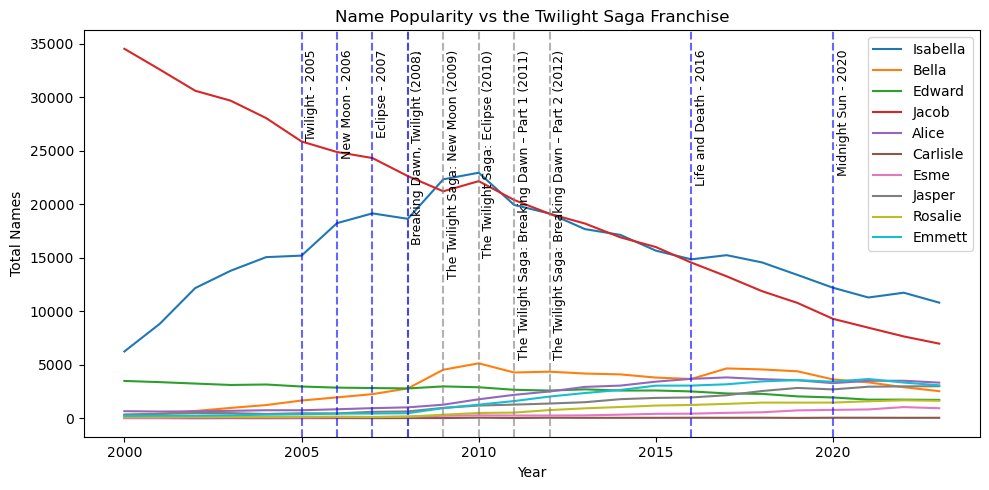

In [350]:
FranchiseVsName(names, TList, "Twilight Saga", TMovieList, TBookList, TShowList, 2000)

| Character      | Observations       |
|----------------|----------------|
| Isabella       | Isabella gained popularity as each book and movie was released until the third movie until there was a decline in the name's popularity.        |
| Bella          | Bella, a variation of Isabella, also gained popularity during the franchise.        |
| Edward         | The popularity of the name Edward slowly decreased as the series continued.         |
| Jacob          | The relationship between babies being named Jacob as the series continued has a negative relationship.      |
| Alice          | Alice became a more popular baby name after the final book was released.       |
| Carisle        | Nobody wanted to name their baby Carisle.     |
| Esme           | Esme had a slight gain in popularity after the release of the thrid movie.        |
| Jasper         | The name Jasper gained popularity after the third movie, Eclipse, was released.      |
| Rosalie        | The number of babies with the name Rosalie steadily increased after the first movie hit theaters.         |
| Emmett         | Popularity of the name Emmett began increasing after the final book and the release of the first movie in the franchise. 


## Conclusion:
This project shows the relationships between name, location, time period, and cultural influence. 
By exploring naming trends across decades, states, and analyzing the impact of popular media, we can see how people are influenced by the world around them.  If I had more time, I would find a way to combine these visualizations to help develope a better sense of how location, year, and culture affect naming trends.

Using heatmaps provided a compelling view into the evolution of spelling and name variants over time. These visualizations revealed when particular variations peaked in popularity and how newer forms of traditional names emerged. We could see the fluctuations in naming/spelling trends over time. If I combined the geopandas graph with the name variation graph, we would be able to see where those names (and their variations) were most popular during the years that popularity peaked. 

Using a line graph, we could also see the impact of pop culture. Using popular movie, tv-show, book franchises, we can look at how character name popularity spiked or declined in correlation with movie, show, or book releases.

## Bibliography

Using Geopandas:
1. https://jcutrer.com/python/learn-geopandas-plotting-usmaps
2. https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
3. https://geopandas.org/en/stable/
4. https://github.com/joncutrer/geopandas-tutorial
5. https://stackoverflow.com/questions/60870128/cant-install-geopandas-in-anaconda-environment (the reason I couldn't run anything for two days - I made the mistake of using pip instead of coda which apparently doesn't work well with windows computers)
6. https://seaborn.pydata.org/tutorial/function_overview.html
7. https://docs.python.org/3/library/os.html
8. https://www.geeksforgeeks.org/os-module-python-examples/